# Leaky Dust Traps

This notebook reproduces the figures of the publication: [Leaky Dust Traps: How Fragmentation impacts Dust Filtering by Planets](https://doi.org/10.1051/0004-6361/202245512). The data files required for the plots can be produced by running the setups in the [repository](https://github.com/stammler/leaky_dust_traps/). Please note, that some of the models will take several days to run.

## Imports

`DustPy` will raise a warning that a newer version is available. This should be ignored, since the models presented in the publication were run with version `1.0.1`.

In [1]:
from dustpy import constants as c
from dustpy import hdf5writer
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import golden
from scipy.interpolate import interp1d
from types import SimpleNamespace
import os


A newer version of DustPy is available.
This version:   1.0.1
Latest version: 1.0.2

Upgrade with
pip install dustpy --upgrade



## Helper Function

This helper function will return the necessary data as a `SimpleNamespace` object. This avoids reading the entire data set.

In [2]:
def read_data(model):
    wrtr = hdf5writer()
    wrtr.datadir = os.path.join("../models", model, "data")
    ret = SimpleNamespace()
    ret.a = wrtr.read.sequence("dust.a")
    ret.alpha = wrtr.read.sequence("gas.alpha")
    ret.cs = wrtr.read.sequence("gas.cs")
    ret.deltaRad = wrtr.read.sequence("dust.delta.rad")
    ret.eps = wrtr.read.sequence("dust.eps")
    ret.Fi = wrtr.read.sequence("dust.Fi.tot")
    ret.Hp = wrtr.read.sequence("gas.Hp")
    ret.m = wrtr.read.sequence("grid.m")
    ret.Ms = wrtr.read.sequence("star.M")
    ret.OmegaK = wrtr.read.sequence("grid.OmegaK")
    ret.r = wrtr.read.sequence("grid.r")
    ret.ri = wrtr.read.sequence("grid.ri")
    ret.rhos = wrtr.read.sequence("dust.rhos")
    ret.SigmaDust = wrtr.read.sequence("dust.Sigma")
    ret.SigmaGas = wrtr.read.sequence("gas.Sigma")
    ret.St = wrtr.read.sequence("dust.St")
    ret.t = wrtr.read.sequence("t")
    ret.T = wrtr.read.sequence("gas.T")
    ret.vfrag = wrtr.read.sequence("dust.v.frag")
    ret.vr = wrtr.read.sequence("dust.v.rad")
    try:
        ret.Mp = wrtr.read.sequence("planets.p00.M")
    except:
        pass
    
    ret.Miso = 25. * c.M_earth * (20.*ret.Hp[...]/ret.r[...])**3 * ret.Ms[..., None]/c.M_sun
    
    A = np.mean(ret.m[0, 1:]/ret.m[0, :-1])
    B = 2 * (A-1) / (A+1)
    ret.sigmaDust = ret.SigmaDust / B
    
    F_tot = np.empty_like(ret.St)
    for i in range(len(ret.t)):
        _f = interp1d(ret.ri[i, ...], ret.Fi[i, ...].T)
        F_tot[i, ...] = _f(ret.r[i, ...]).T
    ret.F_tot_peb = -2.*np.pi*ret.r[...]*F_tot[...].sum(-1)
    
    ret.ir0 = np.abs(ret.r[0]- 2.*c.au).argmin()
    ret.ir1 = np.abs(ret.r[0]-15.*c.au).argmin()
    ret.ir2 = np.abs(ret.r[0]- 5.*c.au).argmin()

    ret.it = np.abs(ret.t-4.e6*c.year).argmin()
    
    M = np.pi*(ret.ri[:, 1:]**2-ret.ri[:, :-1]**2)*ret.SigmaDust[:, ...].sum(-1)
    ret.Mout = np.zeros_like(ret.SigmaGas[:, ...])
    for it in range(len(ret.t)):
        for ir in range(len(ret.r[it, ...])):
            ret.Mout[it, ir] = M[it, ir:].sum() 
    
    return ret

## Loading Models

In [3]:
models = [
    # Toy models
    "toy_saturn",
    "toy_noPlanet",
    "toy_saturn_noFrag",
    "toy_saturn_bouncing",
    "toy_saturn_vFrag100",
    
    # Full models
    "full_noPlanet",
    "full_30Me",
    "full_50Me",
    "full_saturn_deltar2",
    "full_saturn",
    "full_saturn_deltar4",
    "full_saturn_deltar5",
    "full_200Me",
    "full_jupiter",
    
    # Variable planet mass models
    "full_MtSlow",
    "full_MtSlow_deltar4",
    "full_MtSlow_deltar5",
    "full_MtSlow_bouncing",
    "full_MtSlow_bouncing_deltas5",
    "full_MtFast_bouncing_deltas5"
]

In [4]:
model = {}
for m in models:
    print("Loading model: {}".format(m))
    model[m] = read_data(m)

Loading model: toy_saturn
Loading model: toy_noPlanet
Loading model: toy_saturn_noFrag
Loading model: toy_saturn_bouncing
Loading model: toy_saturn_vFrag100
Loading model: full_noPlanet
Loading model: full_30Me
Loading model: full_50Me
Loading model: full_saturn_deltar2
Loading model: full_saturn
Loading model: full_saturn_deltar4
Loading model: full_saturn_deltar5
Loading model: full_200Me
Loading model: full_jupiter
Loading model: full_MtSlow
Loading model: full_MtSlow_deltar4
Loading model: full_MtSlow_deltar5
Loading model: full_MtSlow_bouncing
Loading model: full_MtSlow_bouncing_deltas5
Loading model: full_MtFast_bouncing_deltas5


## Plotting Parameters

In [5]:
smax = np.ceil(np.log10(np.max(model["toy_saturn"].sigmaDust[:, ...])))
lvls = np.linspace(smax-6, smax, 7)
plt.rcParams["figure.dpi"] = 150.
cmap = "magma"
width = 6.
height = width/golden

## Figure 1

**Caption**:  
Panel A: Initial dust distribution. The white lines correspond to Stokes numbers of St = {$10^{−3}$, $10^{−2}$, $10^{−1}$, $10^0$} with the bold white line corresponding to St=1. All other panels show snapshots of models at 1 Myr. Panel B: The fiducial toy model with a Saturn mass planet at 5 AU and a fragmentation velocity of 10 m/s. Panel C: Model without a planet. The vertical dashed lines are the location at which the dust flux is measured in Figure 2. Panel D: Model without fragmentation. Panel E: Model with a reduced fragmentation velocity of 1 m/s. Bottom right: Model with bouncing instead of fragmentation.

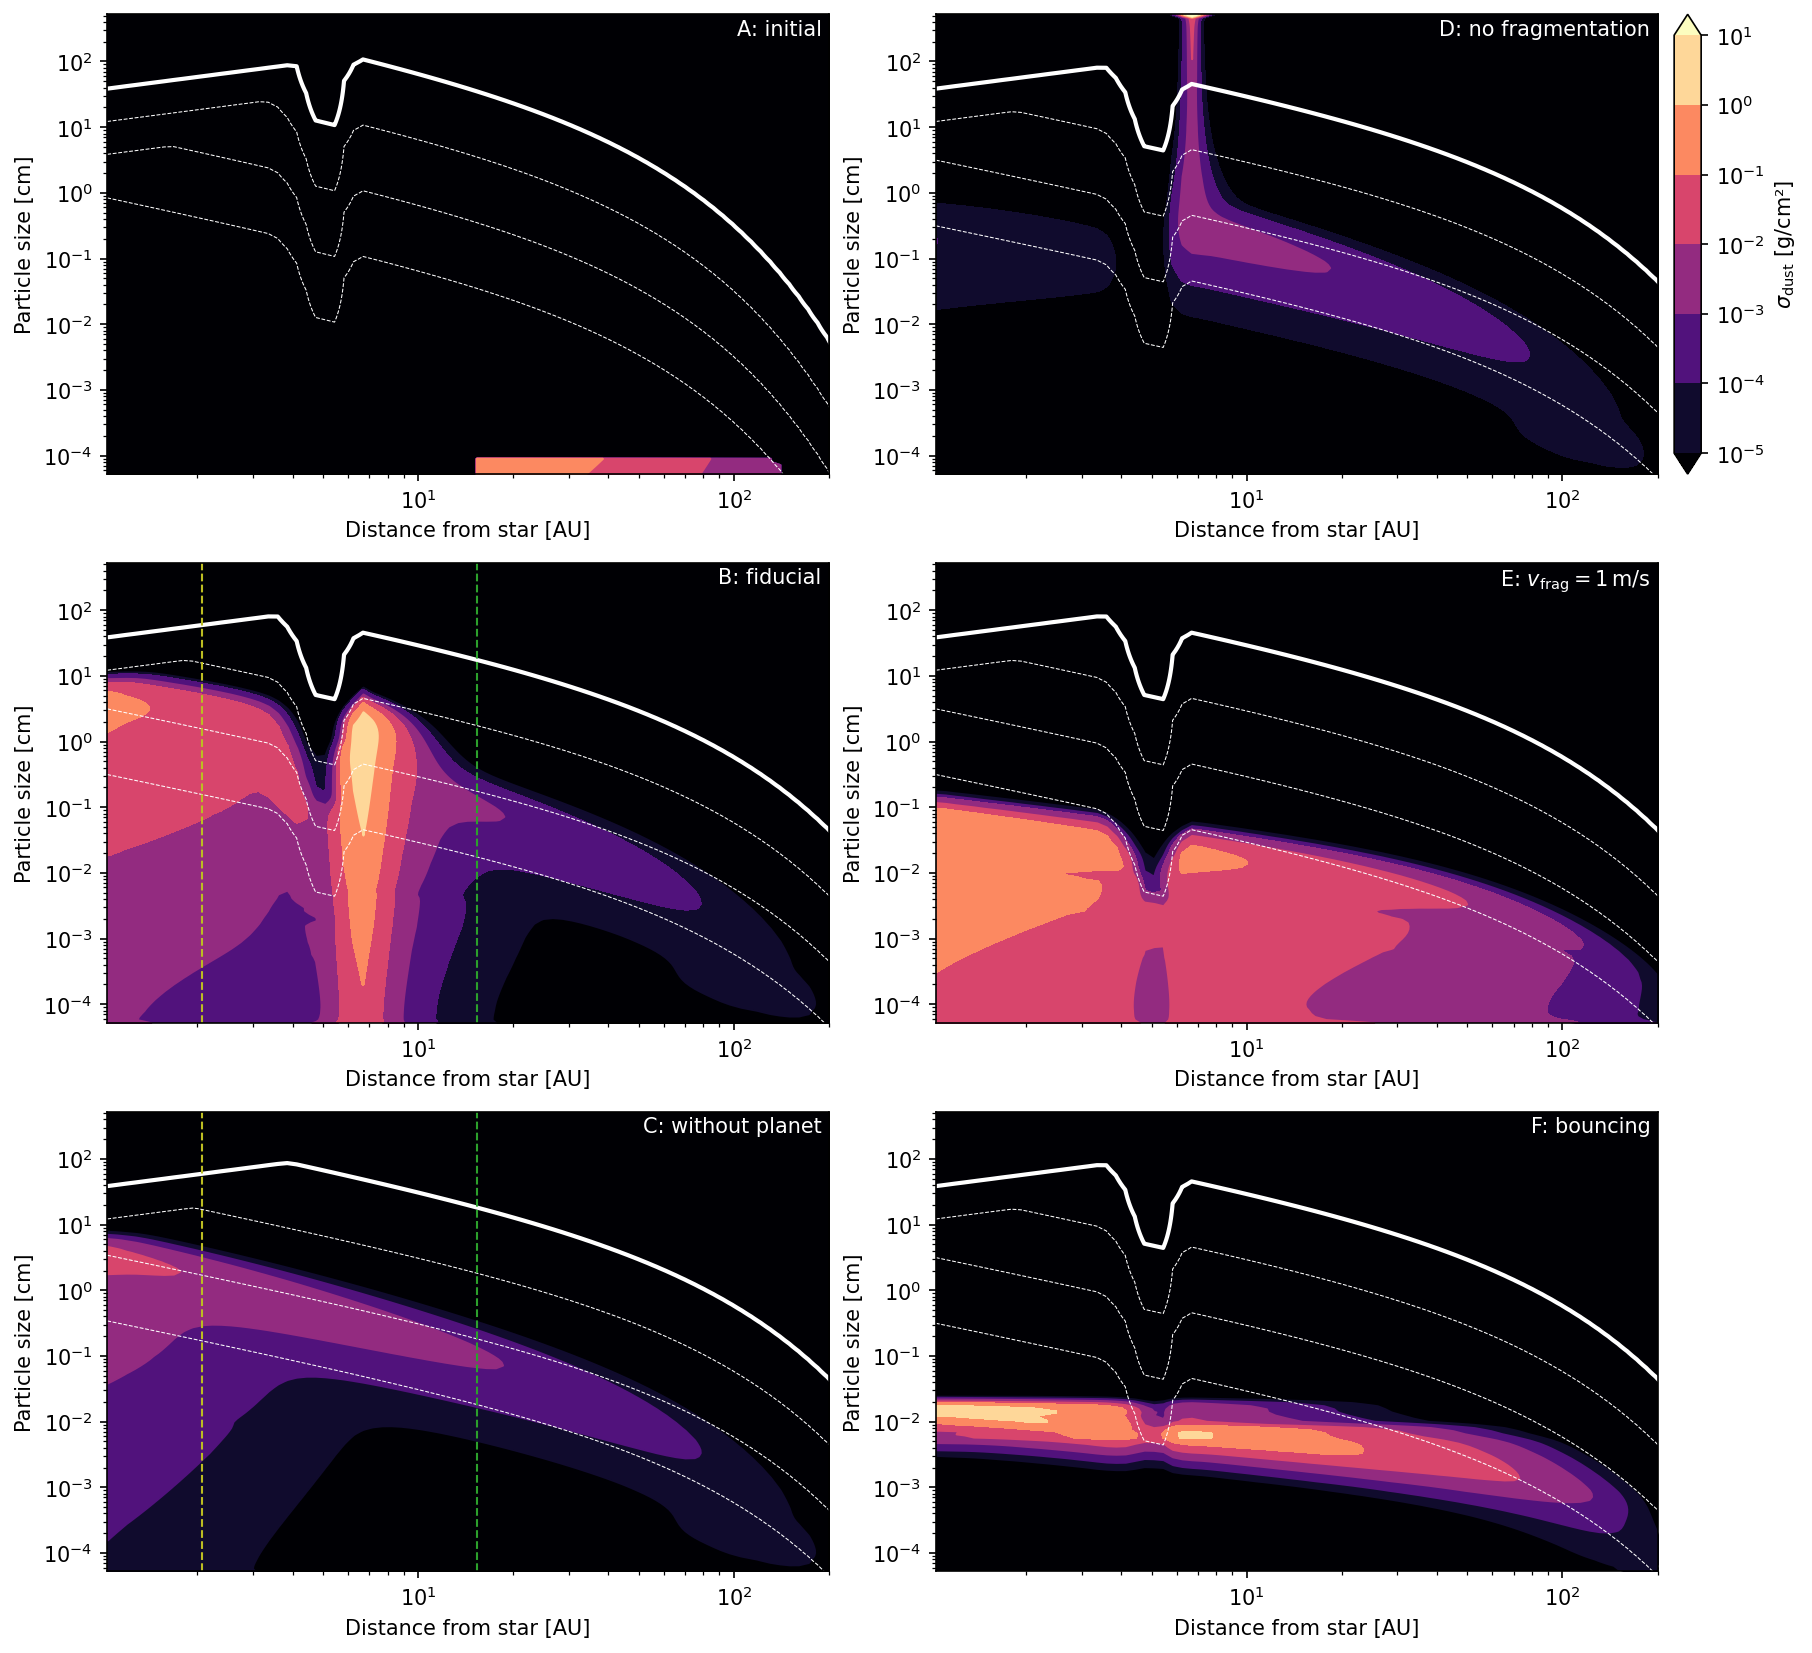

In [6]:
t_plot = 1.e6 * c.year

fig = plt.figure(figsize=(2.*width, 3.*height))

# Panel A
ax00 = fig.add_subplot(321)
it = np.argmin(np.abs(model["toy_saturn"].t-t_plot))
plot00 = ax00.contourf(model["toy_saturn"].r[0, ...]/c.au, model["toy_saturn"].a[0, 0, ...], np.log10(model["toy_saturn"].sigmaDust[0, ...].T), levels=lvls, extend="both", cmap=cmap)
for collection in plot00.collections:
    collection.set_edgecolor("face")
ax00.contour(model["toy_saturn"].r[0, ...]/c.au, model["toy_saturn"].a[0, 0, ...], model["toy_saturn"].St[0, ...].T, levels=[1.], colors="white", linewidths=2)
ax00.contour(model["toy_saturn"].r[0, ...]/c.au, model["toy_saturn"].a[it, 0, ...], model["toy_saturn"].St[0, ...].T, levels=[1.e-3, 1.e-2, 1.e-1], colors="white", linewidths=0.5, linestyles="--")
ax00.text(.99, .99, "A: initial", va="top", ha="right", color="white", transform=ax00.transAxes)
ax00.set_xlabel("Distance from star [AU]")
ax00.set_ylabel("Particle size [cm]")
ax00.set_xscale("log")
ax00.set_yscale("log")
ax00.set_xlim(model["toy_saturn"].r[0, 0]/c.au, 200.)

# Panel B
ax10 = fig.add_subplot(323)
it = np.argmin(np.abs(model["toy_saturn"].t-t_plot))
plot10 = ax10.contourf(model["toy_saturn"].r[it, ...]/c.au, model["toy_saturn"].a[it, 0, ...], np.log10(model["toy_saturn"].sigmaDust[it, ...].T), levels=lvls, extend="both", cmap=cmap)
for collection in plot10.collections:
    collection.set_edgecolor("face")
ax10.contour(model["toy_saturn"].r[it, ...]/c.au, model["toy_saturn"].a[it, 0, ...], model["toy_saturn"].St[it, ...].T, levels=[1.], colors="white", linewidths=2)
ax10.contour(model["toy_saturn"].r[it, ...]/c.au, model["toy_saturn"].a[it, 0, ...], model["toy_saturn"].St[it, ...].T, levels=[1.e-3, 1.e-2, 1.e-1], colors="white", linewidths=0.5, linestyles="--")
ax10.axvline(model["toy_saturn"].r[it, model["toy_saturn"].ir0]/c.au, ls="--", c="C8", lw=1)
ax10.axvline(model["toy_saturn"].r[it, model["toy_saturn"].ir1]/c.au, ls="--", c="C2", lw=1)
ax10.text(.99, .99, "B: fiducial", va="top", ha="right", color="white", transform=ax10.transAxes)
ax10.set_xlabel("Distance from star [AU]")
ax10.set_ylabel("Particle size [cm]")
ax10.set_xscale("log")
ax10.set_yscale("log")
ax10.set_xlim(model["toy_saturn"].r[0, 0]/c.au, 200.)

# Panel C
ax20 = fig.add_subplot(325)
it = np.argmin(np.abs(model["toy_noPlanet"].t-t_plot))
plot20 = ax20.contourf(model["toy_noPlanet"].r[it, ...]/c.au, model["toy_noPlanet"].a[it, 0, ...], np.log10(model["toy_noPlanet"].sigmaDust[it, ...].T), levels=lvls, extend="both", cmap=cmap)
for collection in plot20.collections:
    collection.set_edgecolor("face")
ax20.contour(model["toy_noPlanet"].r[it, ...]/c.au, model["toy_noPlanet"].a[it, 0, ...], model["toy_noPlanet"].St[it, ...].T, levels=[1.], colors="white", linewidths=2)
ax20.contour(model["toy_noPlanet"].r[it, ...]/c.au, model["toy_noPlanet"].a[it, 0, ...], model["toy_noPlanet"].St[it, ...].T, levels=[1.e-3, 1.e-2, 1.e-1], colors="white", linewidths=0.5, linestyles="--")
ax20.axvline(model["toy_noPlanet"].r[it, model["toy_noPlanet"].ir0]/c.au, ls="--", c="C8", lw=1)
ax20.axvline(model["toy_noPlanet"].r[it, model["toy_noPlanet"].ir1]/c.au, ls="--", c="C2", lw=1)
ax20.text(.99, .99, "C: without planet", va="top", ha="right", color="white", transform=ax20.transAxes)
ax20.set_xlabel("Distance from star [AU]")
ax20.set_ylabel("Particle size [cm]")
ax20.set_xscale("log")
ax20.set_yscale("log")
ax20.set_xlim(model["toy_noPlanet"].r[0, 0]/c.au, 200.)

# Panel D
ax01 = fig.add_subplot(322)
it = np.argmin(np.abs(model["toy_saturn_noFrag"].t-t_plot))
plot01 = ax01.contourf(model["toy_saturn_noFrag"].r[it, ...]/c.au, model["toy_saturn_noFrag"].a[it, 0, ...], np.log10(model["toy_saturn_noFrag"].sigmaDust[it, ...].T), levels=lvls, extend="both", cmap=cmap)
for collection in plot01.collections:
    collection.set_edgecolor("face")
ax01.contour(model["toy_saturn_noFrag"].r[it, ...]/c.au, model["toy_saturn_noFrag"].a[it, 0, ...], model["toy_saturn_noFrag"].St[it, ...].T, levels=[1.], colors="white", linewidths=2)
ax01.contour(model["toy_saturn_noFrag"].r[it, ...]/c.au, model["toy_saturn_noFrag"].a[it, 0, ...], model["toy_saturn_noFrag"].St[it, ...].T, levels=[1.e-3, 1.e-2, 1.e-1], colors="white", linewidths=0.5, linestyles="--")
ax01.text(.99, .99, "D: no fragmentation", va="top", ha="right", color="white", transform=ax01.transAxes)
ax01.set_xlabel("Distance from star [AU]")
ax01.set_ylabel("Particle size [cm]")
ax01.set_xscale("log")
ax01.set_yscale("log")
ax01.set_xlim(model["toy_saturn_noFrag"].r[0, 0]/c.au, 200.)

# Panel E
ax11 = fig.add_subplot(324)
it = np.argmin(np.abs(model["toy_saturn_vFrag100"].t-t_plot))
plot11 = ax11.contourf(model["toy_saturn_vFrag100"].r[it, ...]/c.au, model["toy_saturn_vFrag100"].a[it, 0, ...], np.log10(model["toy_saturn_vFrag100"].sigmaDust[it, ...].T), levels=lvls, extend="both", cmap=cmap)
for collection in plot11.collections:
    collection.set_edgecolor("face")
ax11.contour(model["toy_saturn_vFrag100"].r[it, ...]/c.au, model["toy_saturn_vFrag100"].a[it, 0, ...], model["toy_saturn_vFrag100"].St[it, ...].T, levels=[1.], colors="white", linewidths=2)
ax11.contour(model["toy_saturn_vFrag100"].r[it, ...]/c.au, model["toy_saturn_vFrag100"].a[it, 0, ...], model["toy_saturn_vFrag100"].St[it, ...].T, levels=[1.e-3, 1.e-2, 1.e-1], colors="white", linewidths=0.5, linestyles="--")
ax11.text(.99, .99, "E: $v_\mathrm{frag} = 1\,\mathrm{m/s}$", va="top", ha="right", color="white", transform=ax11.transAxes)
ax11.set_xlabel("Distance from star [AU]")
ax11.set_ylabel("Particle size [cm]")
ax11.set_xscale("log")
ax11.set_yscale("log")
ax11.set_xlim(model["toy_saturn_vFrag100"].r[0, 0]/c.au, 200.)

# Panel F
ax21 = fig.add_subplot(326)
it = np.argmin(np.abs(model["toy_saturn_bouncing"].t-t_plot))
plot21 = ax21.contourf(model["toy_saturn_bouncing"].r[it, ...]/c.au, model["toy_saturn_bouncing"].a[it, 0, ...], np.log10(model["toy_saturn_bouncing"].sigmaDust[it, ...].T), levels=lvls, extend="both", cmap=cmap)
for collection in plot21.collections:
    collection.set_edgecolor("face")
ax21.contour(model["toy_saturn_bouncing"].r[it, ...]/c.au, model["toy_saturn_bouncing"].a[it, 0, ...], model["toy_saturn_bouncing"].St[it, ...].T, levels=[1.], colors="white", linewidths=2)
ax21.contour(model["toy_saturn_bouncing"].r[it, ...]/c.au, model["toy_saturn_bouncing"].a[it, 0, ...], model["toy_saturn_bouncing"].St[it, ...].T, levels=[1.e-3, 1.e-2, 1.e-1], colors="white", linewidths=0.5, linestyles="--")
ax21.text(.99, .99, "F: bouncing", va="top", ha="right", color="white", transform=ax21.transAxes)
ax21.set_xlabel("Distance from star [AU]")
ax21.set_ylabel("Particle size [cm]")
ax21.set_xscale("log")
ax21.set_yscale("log")
ax21.set_xlim(model["toy_saturn_bouncing"].r[0, 0]/c.au, 200.)

fig.tight_layout()
fig.subplots_adjust(right=0.925)

pos01 = ax01.get_position()
cb_ax = fig.add_axes([1.01*pos01.x1, pos01.y0, 0.015, pos01.y1-pos01.y0])
cbar = fig.colorbar(plot00, cax=cb_ax)
cbar.set_label("$\sigma_\mathrm{dust}$ [g/cm²]")
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels(["$10^{{{:2.0f}}}$".format(e) for e in cbar.get_ticks()])

## Figure 2

**Caption:**  
Top: Comparison of the dust flux in the inner disk (at 2 AU) and outer disk (at 15 AU) in the toy model with a Saturn mass planet at 5 AU (panel B in Figure 1) and a model without a planet (panel C in Figure 1). Both green 15 AU lines overlap. Bottom: Total dust mass accreted through the inner disk over time.

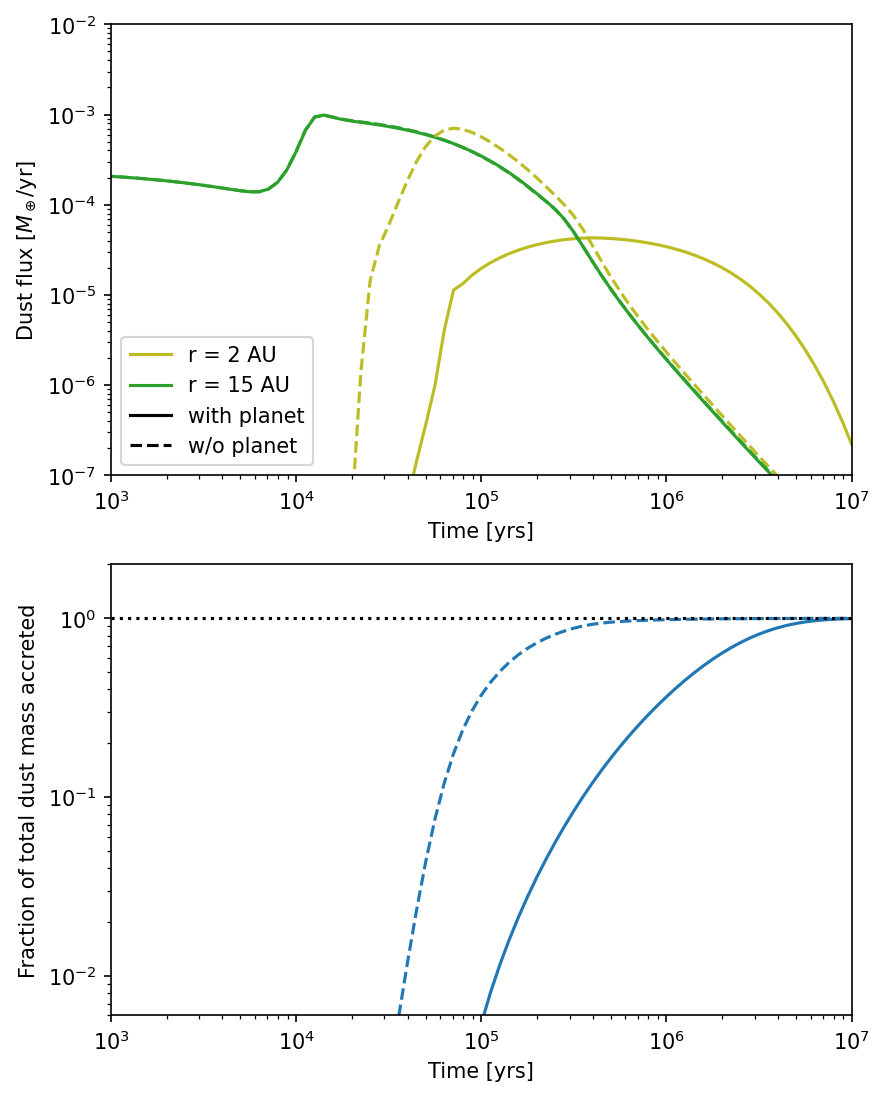

In [7]:
fig = plt.figure(figsize=(width, 2.*height))

ax1 = fig.add_subplot(211)
ax1.loglog(model["toy_saturn"].t/c.year, model["toy_saturn"].F_tot_peb[:, model["toy_saturn"].ir0]/c.M_earth*c.year, c="C8", label="r = 2 AU")
ax1.loglog(model["toy_saturn"].t/c.year, model["toy_saturn"].F_tot_peb[:, model["toy_saturn"].ir1]/c.M_earth*c.year, c="C2", label="r = 15 AU")
ax1.loglog(model["toy_noPlanet"].t/c.year, model["toy_noPlanet"].F_tot_peb[:, model["toy_noPlanet"].ir0]/c.M_earth*c.year, c="C8", ls="--")
ax1.loglog(model["toy_noPlanet"].t/c.year, model["toy_noPlanet"].F_tot_peb[:, model["toy_noPlanet"].ir1]/c.M_earth*c.year, c="C2", ls="--")
ax1.loglog(0., 0., c="black", ls="-", label="with planet")
ax1.loglog(0., 0., c="black", ls="--", label="w/o planet")
ax1.set_xlabel("Time [yrs]")
ax1.set_ylabel("Dust flux [$M_\oplus$/yr]")
ax1.set_xlim(model["toy_saturn"].t[1]/c.year, model["toy_saturn"].t[-1]/c.year)
ax1.set_ylim(1.e-7, 1.e-2)
ax1.legend(loc="lower left")

ax2 = fig.add_subplot(212)
ax2.loglog(model["toy_saturn"].t[:]/c.year, 1.-model["toy_saturn"].Mout[:, model["toy_saturn"].ir0]/model["toy_saturn"].Mout[0, model["toy_saturn"].ir0], c="C0", ls="-")
ax2.loglog(model["toy_noPlanet"].t[:]/c.year, 1.-model["toy_noPlanet"].Mout[:, model["toy_noPlanet"].ir0]/model["toy_noPlanet"].Mout[0, model["toy_noPlanet"].ir0], c="C0", ls="--")
ax2.axhline(1, c="black", ls=":")
ax2.set_xlim(model["toy_saturn"].t[1]/c.year, model["toy_saturn"].t[-1]/c.year)
ax2.set_ylim(6.e-3, 2.e0)
ax2.set_xlabel("Time [yrs]")
ax2.set_ylabel("Fraction of total dust mass accreted")

fig.tight_layout()

## Figure 3

**Caption:**  
Top: Dust flux through the planetary gap in models with different planet masses. The blue line is for a model without a planet. The dashed, dotted, and dash-dotted red lines show additional simulations with a Saturn mass planet for different radial dust diffusivity parameters $\delta_r$. Bottom: Total fraction of outer dust mass accreted through the planetary gap.

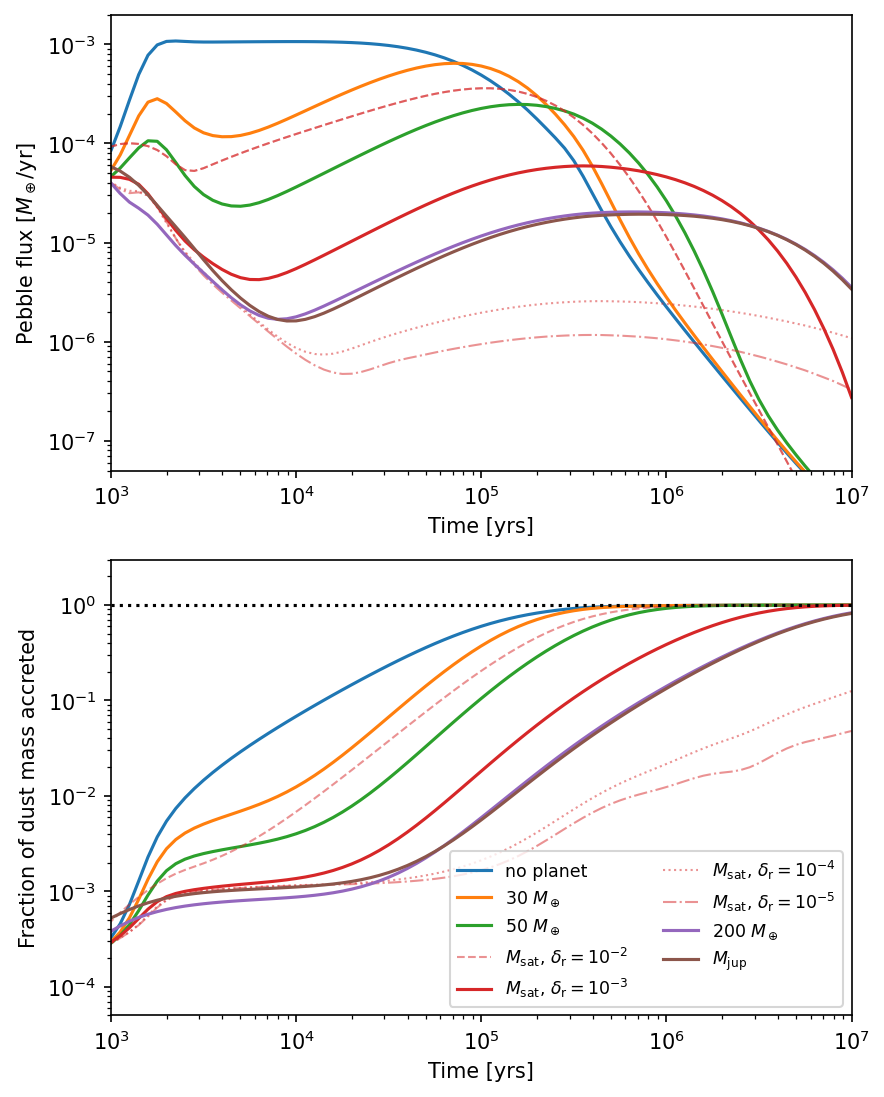

In [8]:
fig = plt.figure(figsize=(width, 2.*height))

ax1 = fig.add_subplot(211)
ax1.loglog(model["full_noPlanet"].t/c.year, model["full_noPlanet"].F_tot_peb[:, model["full_noPlanet"].ir2]/c.M_earth*c.year, c="C0")
ax1.loglog(model["full_30Me"].t/c.year, model["full_30Me"].F_tot_peb[:, model["full_30Me"].ir2]/c.M_earth*c.year, c="C1")
ax1.loglog(model["full_50Me"].t/c.year, model["full_50Me"].F_tot_peb[:, model["full_50Me"].ir2]/c.M_earth*c.year, c="C2")
ax1.loglog(model["full_saturn_deltar2"].t/c.year, model["full_saturn_deltar2"].F_tot_peb[:, model["full_saturn_deltar2"].ir2]/c.M_earth*c.year, c="C3", ls="--", lw=1, alpha=0.5)
ax1.loglog(model["full_saturn"].t/c.year, model["full_saturn"].F_tot_peb[:, model["full_saturn"].ir2]/c.M_earth*c.year, c="C3")
ax1.loglog(model["full_saturn_deltar2"].t/c.year, model["full_saturn_deltar2"].F_tot_peb[:, model["full_saturn_deltar2"].ir2]/c.M_earth*c.year, c="C3", ls="--", lw=1, alpha=0.5)
ax1.loglog(model["full_saturn_deltar4"].t/c.year, model["full_saturn_deltar4"].F_tot_peb[:, model["full_saturn_deltar4"].ir2]/c.M_earth*c.year, c="C3", ls=":", lw=1, alpha=0.5)
ax1.loglog(model["full_saturn_deltar5"].t/c.year, model["full_saturn_deltar5"].F_tot_peb[:, model["full_saturn_deltar5"].ir2]/c.M_earth*c.year, c="C3", ls="-.", lw=1, alpha=0.5)
ax1.loglog(model["full_200Me"].t/c.year, model["full_200Me"].F_tot_peb[:, model["full_200Me"].ir2]/c.M_earth*c.year, c="C4")
ax1.loglog(model["full_jupiter"].t/c.year, model["full_jupiter"].F_tot_peb[:, model["full_jupiter"].ir2]/c.M_earth*c.year, c="C5")
ax1.set_xlabel("Time [yrs]")
ax1.set_ylabel("Pebble flux [$M_\oplus$/yr]")
ax1.set_xlim(model["full_saturn"].t[1]/c.year, model["full_saturn"].t[-1]/c.year)
ax1.set_ylim(5.e-8, 2.e-3)

ax2 = fig.add_subplot(212)
ax2.loglog(model["full_noPlanet"].t[:]/c.year, 1.-model["full_noPlanet"].Mout[:, model["full_noPlanet"].ir2]/model["full_noPlanet"].Mout[0, model["full_noPlanet"].ir2], label="no planet", c="C0")
ax2.loglog(model["full_30Me"].t[:]/c.year, 1.-model["full_30Me"].Mout[:, model["full_30Me"].ir2]/model["full_30Me"].Mout[0, model["full_30Me"].ir2], label="30 $M_\oplus$", c="C1")
ax2.loglog(model["full_50Me"].t[:]/c.year, 1.-model["full_50Me"].Mout[:, model["full_50Me"].ir2]/model["full_50Me"].Mout[0, model["full_50Me"].ir2], label="50 $M_\oplus$", c="C2")
ax2.loglog(model["full_saturn_deltar2"].t[:]/c.year, 1.-model["full_saturn_deltar2"].Mout[:, model["full_saturn_deltar2"].ir2]/model["full_saturn_deltar2"].Mout[0, model["full_saturn_deltar2"].ir2], label="$M_\mathrm{sat}$, $\delta_\mathrm{r}=10^{-2}$", c="C3", ls="--", lw=1, alpha=0.5)
ax2.loglog(model["full_saturn"].t[:]/c.year, 1.-model["full_saturn"].Mout[:, model["full_saturn"].ir2]/model["full_saturn"].Mout[0, model["full_saturn"].ir2], label="$M_\mathrm{sat}$, $\delta_\mathrm{r}=10^{-3}$", c="C3")
ax2.loglog(model["full_saturn_deltar4"].t[:]/c.year, 1.-model["full_saturn_deltar4"].Mout[:, model["full_saturn_deltar4"].ir2]/model["full_saturn_deltar4"].Mout[0, model["full_saturn_deltar4"].ir2], label="$M_\mathrm{sat}$, $\delta_\mathrm{r}=10^{-4}$", c="C3", ls=":", lw=1, alpha=0.5)
ax2.loglog(model["full_saturn_deltar5"].t[:]/c.year, 1.-model["full_saturn_deltar5"].Mout[:, model["full_saturn_deltar5"].ir2]/model["full_saturn_deltar5"].Mout[0, model["full_saturn_deltar5"].ir2], label="$M_\mathrm{sat}$, $\delta_\mathrm{r}=10^{-5}$", c="C3", ls="-.", lw=1, alpha=0.5)
ax2.loglog(model["full_200Me"].t[:]/c.year, 1.-model["full_200Me"].Mout[:, model["full_200Me"].ir2]/model["full_200Me"].Mout[0, model["full_200Me"].ir2], label="200 $M_\oplus$", c="C4")
ax2.loglog(model["full_jupiter"].t[:]/c.year, 1.-model["full_jupiter"].Mout[:, model["full_jupiter"].ir2]/model["full_jupiter"].Mout[0, model["full_jupiter"].ir2], label="$M_\mathrm{jup}$", c="C5")
ax2.axhline(1, c="black", ls=":")
ax2.set_xlim(model["full_saturn"].t[1]/c.year, model["full_saturn"].t[-1]/c.year)
ax2.set_ylim(5.e-5, 3.e0)
ax2.set_xlabel("Time [yrs]")
ax2.set_ylabel("Fraction of dust mass accreted")
ax2.legend(loc="lower right", fontsize="small", ncol=2)

fig.tight_layout()

## Figure 4

**Caption:**  
Evolution of the planetary mass in the time-dependent model. The solid line shows the default model where the planet reaches 20 $M_\oplus$ at 1 Myrs. The dashed line shows the evolution in a model with rapid early growth in which the planet reaches 40 $M_\oplus$ at 1 Myr. Bottom
left: Fraction of outer disk dust mass accreted through the gap after 1 Myr in the default planetary mass evolution model for different values of dust diffusivity $\delta_r$ with fragmentation limited growth. Bottom right: The solid lines show the fraction of outer disk material accreted through the gap after 1 Myr for bouncing limited growth for different values of the $\delta_i$ parameters in the default planetary growth model. The dashed green line shows a model of bouncing limited growth with $\delta_i=10^{-5}$ and rapid early growth of the planet (dashed line in top left panel). The vertical lines mark 4 Myr until which both reservoirs need to be separated. Top right: Snapshot of the dust distribution at 4 Myr for the model with bouncing limited growth and $\delta_i=10^{-5}$ (dashed green line in bottom right panel). The inner disk is depleted in dust and only supplied with small amounts of outer disk material.

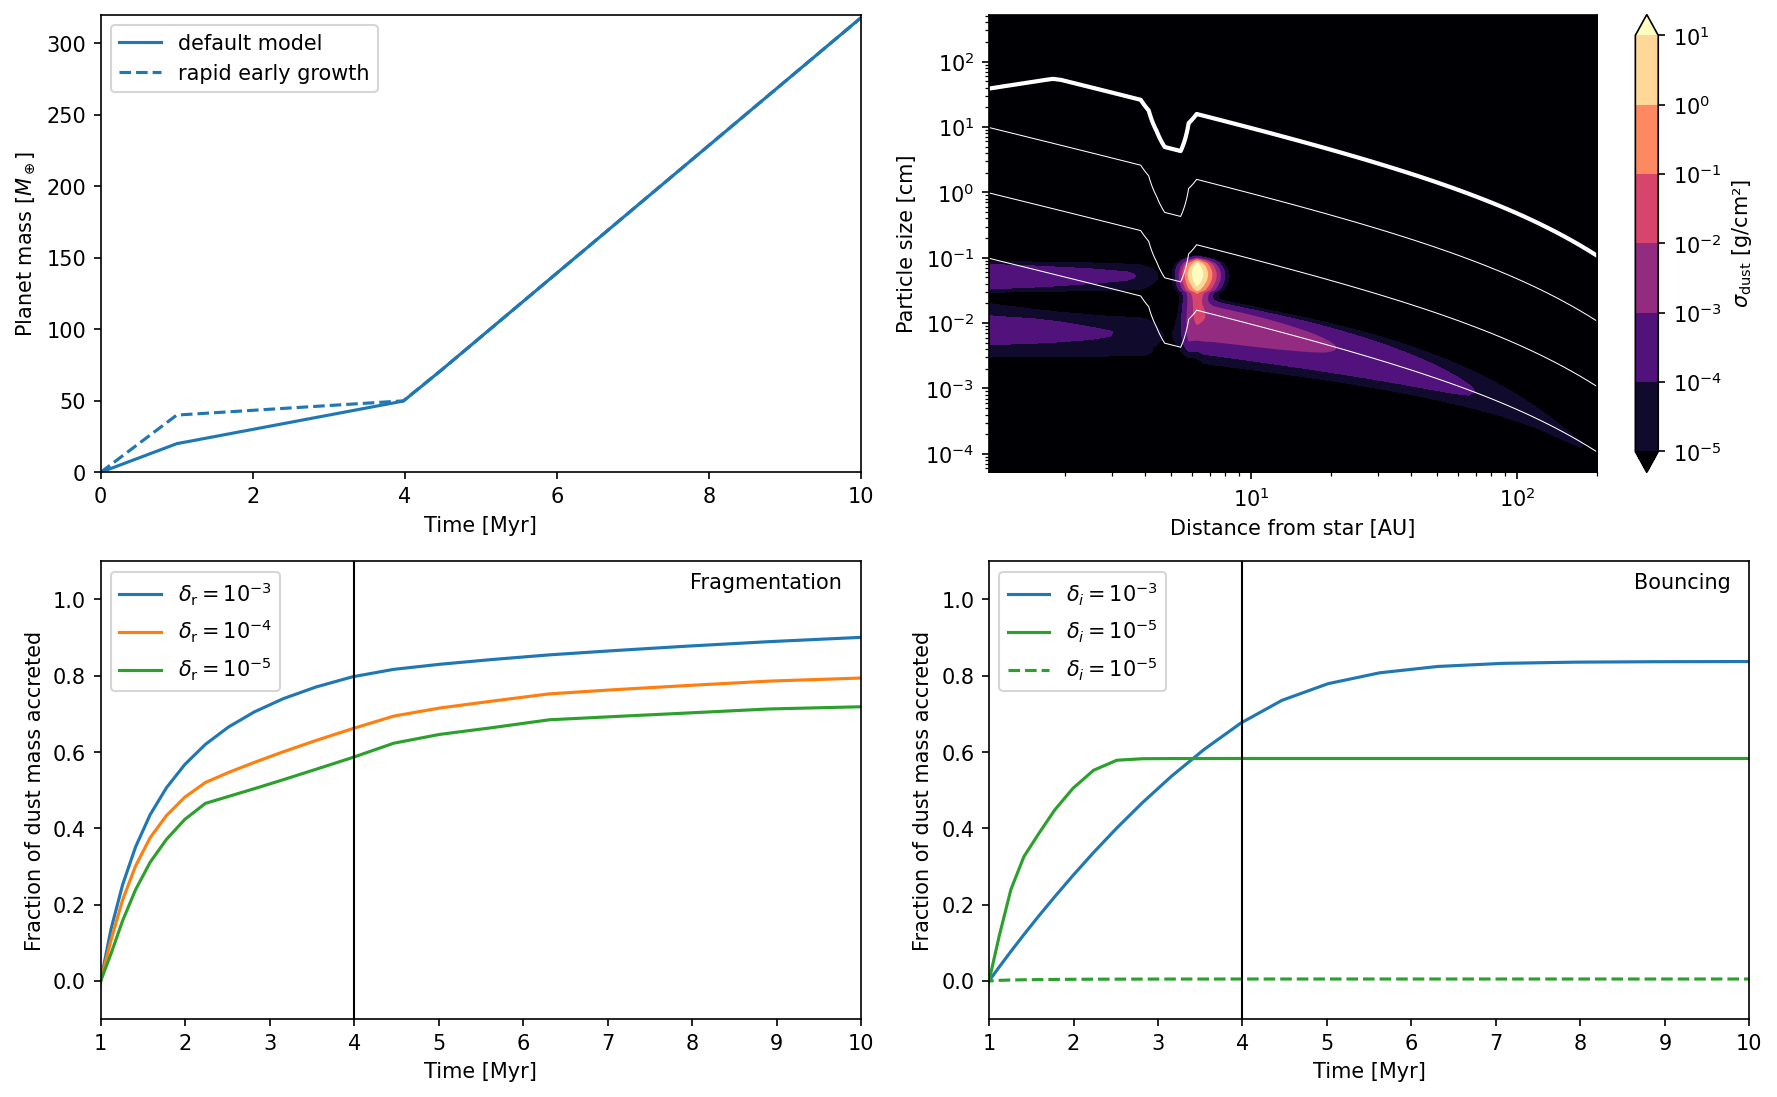

In [9]:
fig = plt.figure(figsize=(2.*width, 2.*height))

ax00 = fig.add_subplot(221)
ax00.plot(model["full_MtSlow"].t/(1.e6*c.year), model["full_MtSlow"].Mp/c.M_earth, c="C0", label="default model")
ax00.plot(model["full_MtFast_bouncing_deltas5"].t/(1.e6*c.year), model["full_MtFast_bouncing_deltas5"].Mp/c.M_earth, c="C0", ls="--", label="rapid early growth")
ax00.set_xlabel("Time [Myr]")
ax00.set_ylabel("Planet mass [$M_\oplus$]")
ax00.legend(loc="upper left")
ax00.set_xlim(0., 10.)
ax00.set_ylim(0., 320.)

ax10 = fig.add_subplot(223)
ax10.semilogy(model["full_MtSlow"].t[:]/(1.e6*c.year), 1.-model["full_MtSlow"].Mout[:, model["full_MtSlow"].ir2]/model["full_MtSlow"].Mout[it, model["full_MtSlow"].ir2], label="$\delta_\mathrm{r} = 10^{-3}$")
ax10.semilogy(model["full_MtSlow_deltar4"].t[:]/(1.e6*c.year), 1.-model["full_MtSlow_deltar4"].Mout[:, model["full_MtSlow_deltar4"].ir2]/model["full_MtSlow_deltar4"].Mout[it, model["full_MtSlow_deltar4"].ir2], label="$\delta_\mathrm{r} = 10^{-4}$")
ax10.semilogy(model["full_MtSlow_deltar5"].t[:]/(1.e6*c.year), 1.-model["full_MtSlow_deltar5"].Mout[:, model["full_MtSlow_deltar5"].ir2]/model["full_MtSlow_deltar5"].Mout[it, model["full_MtSlow_deltar5"].ir2], label="$\delta_\mathrm{r} = 10^{-5}$")
ax10.axvline(4, lw=1, c="black")
ax10.set_yscale("linear")
ax10.set_xlim(1., 10.)
ax10.set_ylim(-0.1, 1.1)
ax10.set_xlabel("Time [Myr]")
ax10.set_ylabel("Fraction of dust mass accreted")
ax10.legend(loc="upper left")
ax10.text(0.975, 0.975, "Fragmentation", transform=ax10.transAxes, ha="right", va="top")

ax01 = fig.add_subplot(222)
plot01 = ax01.contourf(model["full_MtFast_bouncing_deltas5"].r[model["full_MtFast_bouncing_deltas5"].it, ...]/c.au, model["full_MtFast_bouncing_deltas5"].a[model["full_MtFast_bouncing_deltas5"].it, 0, ...], np.log10(model["full_MtFast_bouncing_deltas5"].sigmaDust[model["full_MtFast_bouncing_deltas5"].it, ...].T), levels=lvls, extend="both", cmap=cmap)
for collection in plot01.collections:
    collection.set_edgecolor("face")
cbar01 = plt.colorbar(plot01)
cbar01.set_label("$\sigma_\mathrm{dust}$ [g/cm²]")
cbar01.set_ticks(cbar01.get_ticks())
cbar01.set_ticklabels(["$10^{{{:2.0f}}}$".format(e) for e in cbar01.get_ticks()])
ax01.contour(model["full_MtFast_bouncing_deltas5"].r[model["full_MtFast_bouncing_deltas5"].it, ...]/c.au, model["full_MtFast_bouncing_deltas5"].a[model["full_MtFast_bouncing_deltas5"].it, 0, ...], model["full_MtFast_bouncing_deltas5"].St[model["full_MtFast_bouncing_deltas5"].it, ...].T, levels=[1.], colors="white", linewidths=2)
ax01.contour(model["full_MtFast_bouncing_deltas5"].r[model["full_MtFast_bouncing_deltas5"].it, ...]/c.au, model["full_MtFast_bouncing_deltas5"].a[model["full_MtFast_bouncing_deltas5"].it, 0, ...], model["full_MtFast_bouncing_deltas5"].St[model["full_MtFast_bouncing_deltas5"].it, ...].T, levels=[1.e-3, 1.e-2, 1.e-1], colors="white", linewidths=0.5)
ax01.set_xlabel("Distance from star [AU]")
ax01.set_ylabel("Particle size [cm]")
ax01.set_xscale("log")
ax01.set_yscale("log")
ax01.set_xlim(model["full_MtFast_bouncing_deltas5"].r[0, 0]/c.au, 200.)

ax22 = fig.add_subplot(224)
ax22.semilogy(model["full_MtSlow_bouncing"].t[:]/(1.e6*c.year), 1.-model["full_MtSlow_bouncing"].Mout[:, model["full_MtSlow_bouncing"].ir2]/model["full_MtSlow_bouncing"].Mout[it, model["full_MtSlow_bouncing"].ir2], label="$\delta_i = 10^{-3}$", c="C0")
ax22.semilogy(model["full_MtSlow_bouncing_deltas5"].t[:]/(1.e6*c.year), 1.-model["full_MtSlow_bouncing_deltas5"].Mout[:, model["full_MtSlow_bouncing_deltas5"].ir2]/model["full_MtSlow_bouncing_deltas5"].Mout[it, model["full_MtSlow_bouncing_deltas5"].ir2], label="$\delta_i = 10^{-5}$", c="C2")
ax22.semilogy(model["full_MtFast_bouncing_deltas5"].t[:]/(1.e6*c.year), 1.-model["full_MtFast_bouncing_deltas5"].Mout[:, model["full_MtFast_bouncing_deltas5"].ir2]/model["full_MtFast_bouncing_deltas5"].Mout[it, model["full_MtFast_bouncing_deltas5"].ir2], label="$\delta_i = 10^{-5}$", ls="--", c="C2")
ax22.axvline(4, lw=1, c="black")
ax22.set_yscale("linear")
ax22.set_xlim(1., 10.)
ax22.set_ylim(-0.1, 1.1)
ax22.set_xlabel("Time [Myr]")
ax22.set_ylabel("Fraction of dust mass accreted")
ax22.legend(loc="upper left")
ax22.text(0.975, 0.975, "Bouncing", transform=ax22.transAxes, ha="right", va="top")

fig.tight_layout()